In [62]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [95]:
# Preprocessing the image dataset. Might need to create a new one for additional dataset. 
class EmotionDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_mapping = {}

        current_label_id = 0
        for label in os.listdir(directory):
            label_path = os.path.join(directory, label)
            if os.path.isdir(label_path):
                if label not in self.label_mapping:
                    self.label_mapping[label] = current_label_id
                    current_label_id += 1

                for img in os.listdir(label_path):
                    img_path = os.path.join(label_path, img)
                    self.images.append(img_path)
                    self.labels.append(self.label_mapping[label])
        # print("Label mapping:", self.label_mapping)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)

        return image, label

In [96]:
# Create dataloaders for train, val and test
data_path = os.path.join(os.getcwd(), 'archive')
filepath_train = os.path.join(data_path, 'train')
filepath_test = os.path.join(data_path, 'test')
# transforms = None

transforms = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = EmotionDataset(filepath_train, transform=transforms)
test_dataset = EmotionDataset(filepath_test, transform=transforms)

validation_split = 0.2 
train_sample = int(len(train_dataset) * (1 - validation_split))
val_samples = len(train_dataset) - train_sample
train_dataset, val_dataset = random_split(train_dataset, [train_sample, val_samples], generator=torch.Generator().manual_seed(21))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Label mapping: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
Label mapping: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


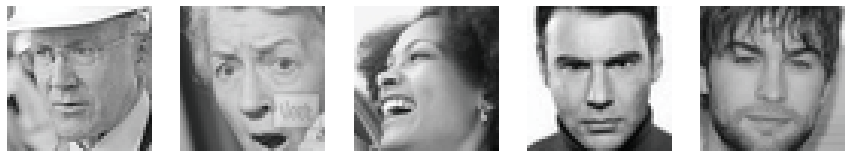

In [65]:
# display some traning samples
def imshow(img):  
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)  
    return img
    
    
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(15, 3))  
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1) 
    img = imshow(images[i])
    ax.imshow(img)
    ax.axis('off')  
plt.show()

In [69]:
# Random Model for demo
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Epoch 1/10, Loss: 1.6314, Train Acc: 34.75%, Val Acc: 43.30%
Epoch 2/10, Loss: 1.3907, Train Acc: 46.19%, Val Acc: 48.50%
Epoch 3/10, Loss: 1.2676, Train Acc: 51.56%, Val Acc: 49.84%
Epoch 4/10, Loss: 1.1807, Train Acc: 54.97%, Val Acc: 52.79%
Epoch 5/10, Loss: 1.1043, Train Acc: 58.04%, Val Acc: 52.72%
Epoch 6/10, Loss: 1.0252, Train Acc: 61.39%, Val Acc: 52.61%
Epoch 7/10, Loss: 0.9559, Train Acc: 64.01%, Val Acc: 52.87%
Epoch 8/10, Loss: 0.8791, Train Acc: 67.03%, Val Acc: 52.91%
Epoch 9/10, Loss: 0.8151, Train Acc: 69.60%, Val Acc: 53.85%
Epoch 10/10, Loss: 0.7403, Train Acc: 72.56%, Val Acc: 53.61%
Training completed. Best Validation Accuracy: 53.85%


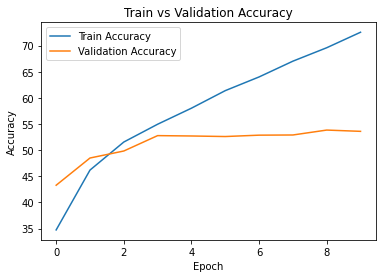

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()

train_acc = []
val_acc= []

num_epoch = 10
best_val_accuracy = 0

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        # print("Image batch shape:", images.shape)
        # print("Label batch shape:", labels.shape)
        # print("Sample labels:", labels[:5])
        optimizer.zero_grad()
        output = model(images)
        if torch.isnan(output).any():
            raise ValueError("NaN values detected in forward pass!")
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)
    # scheduler.step()

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = torch.argmax(output, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_acc.append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {running_loss/len(train_dataloader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model_state_dict.pth')

print("Training completed. Best Validation Accuracy: {:.2f}%".format(best_val_accuracy))

# Plotting train and Validation accuracies
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [71]:
model = CNN()
model.load_state_dict(torch.load('best_model_state_dict.pth'))

model.eval()
model.to(device)
errors = []

correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        # mismatches = predicted != labels
        # if any(mismatches):
        #     errors.append((images[mismatches], labels[mismatches], predicted[mismatches]))
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        
# for imgs, lbls, preds in errors[:5]:  
#     print("True Labels:", lbls)
#     print("Predicted Labels:", preds)
#     imshow(torchvision.utils.make_grid(imgs.cpu()))

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 52.95%


The accuracy is not good. Now, we need to re-examinize the data. Furthermore, we need to implement data augmentation, regularization and fine tuning the model parameters and complexity. 

In [84]:
# The normalization method for ImageNet may not be suitable. Normalizing the dataset according to its own mean and std. 
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

transform = T.Compose([T.Resize((48, 48)), T.ToTensor()])
train_dataset = EmotionDataset(filepath_train, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
mean, std = get_mean_std(train_loader)

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.5077, 0.5077, 0.5077])
Std: tensor([0.2550, 0.2550, 0.2550])


In [90]:
train_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15), 
    T.ColorJitter(brightness=0.3, contrast=0.3), 
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)  
])

t_transforms = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


train_dataset = EmotionDataset(filepath_train, transform=train_transforms)
val_dataset = EmotionDataset(filepath_train, transform=t_transforms) 
test_dataset = EmotionDataset(filepath_test, transform=t_transforms)

total_size = len(train_dataset)
train_size = int(total_size * (1 - validation_split))
val_size = total_size - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(123))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [91]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 6 * 6, 256)  
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(self.pool(F.relu(self.bn3(self.conv3(x)))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

Epoch 1/200, Loss: 1.7013, Train Acc: 31.58%, Val Acc: 37.30%
Epoch 2/200, Loss: 1.5393, Train Acc: 39.98%, Val Acc: 42.76%
Epoch 3/200, Loss: 1.4737, Train Acc: 42.77%, Val Acc: 44.18%
Epoch 4/200, Loss: 1.4253, Train Acc: 45.20%, Val Acc: 47.79%
Epoch 5/200, Loss: 1.3945, Train Acc: 46.75%, Val Acc: 48.82%
Epoch 6/200, Loss: 1.3701, Train Acc: 47.71%, Val Acc: 49.84%
Epoch 7/200, Loss: 1.3428, Train Acc: 48.69%, Val Acc: 50.80%
Epoch 8/200, Loss: 1.3288, Train Acc: 49.50%, Val Acc: 51.24%
Epoch 9/200, Loss: 1.3121, Train Acc: 50.15%, Val Acc: 51.46%
Epoch 10/200, Loss: 1.2930, Train Acc: 50.63%, Val Acc: 50.98%
Epoch 11/200, Loss: 1.2820, Train Acc: 51.33%, Val Acc: 51.31%
Epoch 12/200, Loss: 1.2650, Train Acc: 51.94%, Val Acc: 53.52%
Epoch 13/200, Loss: 1.2523, Train Acc: 52.43%, Val Acc: 52.53%
Epoch 14/200, Loss: 1.2467, Train Acc: 52.78%, Val Acc: 52.51%
Epoch 15/200, Loss: 1.2414, Train Acc: 52.92%, Val Acc: 53.97%
Epoch 16/200, Loss: 1.2351, Train Acc: 53.51%, Val Acc: 52.40%
E

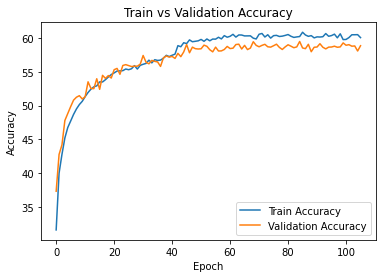

In [92]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN2()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=10, verbose=True)

loss_fn = nn.CrossEntropyLoss()

train_acc = []
val_acc= []

num_epoch = 200 # high epoch for early stopping
best_val_accuracy = 0
patience = 20 # Num of epoch of no improvement in val_acc

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(output, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)

    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            predicted = torch.argmax(output, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_acc.append(val_accuracy)
    
    scheduler.step(val_accuracy)

    # Early stopping logic
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), 'CNN2.pth')
        early_stopping_counter = 0  
    else:
        early_stopping_counter += 1
        
    print(f"Epoch {epoch+1}/{num_epoch}, Loss: {running_loss/len(train_dataloader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
    
    if early_stopping_counter > patience:
        print("Early stopping triggered after epoch {0}".format(epoch+1))
        break

print("Training completed. Best Validation Accuracy: {:.2f}%".format(best_val_accuracy))

# Plotting train and Validation accuracies
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [94]:
model = CNN2()
model.load_state_dict(torch.load('CNN2.pth'))

model.eval()
model.to(device)
errors = []

correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        

test_accuracy = 100 * correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 61.21%


Barely made to 60% test accuracy. The data is harder than it looks. May give ResBlock + inception a try.